# Analyse Long Format Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from src.d00_helpers import helpers as h
import seaborn as sns

In [2]:
# read in long dataframe
df = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//01_processed//2024.03.21_Mastertabelle_long.xlsx',
                   parse_dates=['date'], index_col='Unnamed: 0', dtype={'vaccination': "Int64", 'infection':'Int64'})
df.rename(columns={'patient_id':'ID'}, inplace=True)

In [3]:
# read in basline table to get demographic data
bl = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//00_raw//2024.03.21_Mastertabelle.xlsx')
bl_sub=bl[['ID','Alter','Dialyse','Geschlecht']]

In [4]:
# Add information of Dialyse group
df = pd.merge(df, bl[['ID', 'Dialyse']], on='ID', how='left')

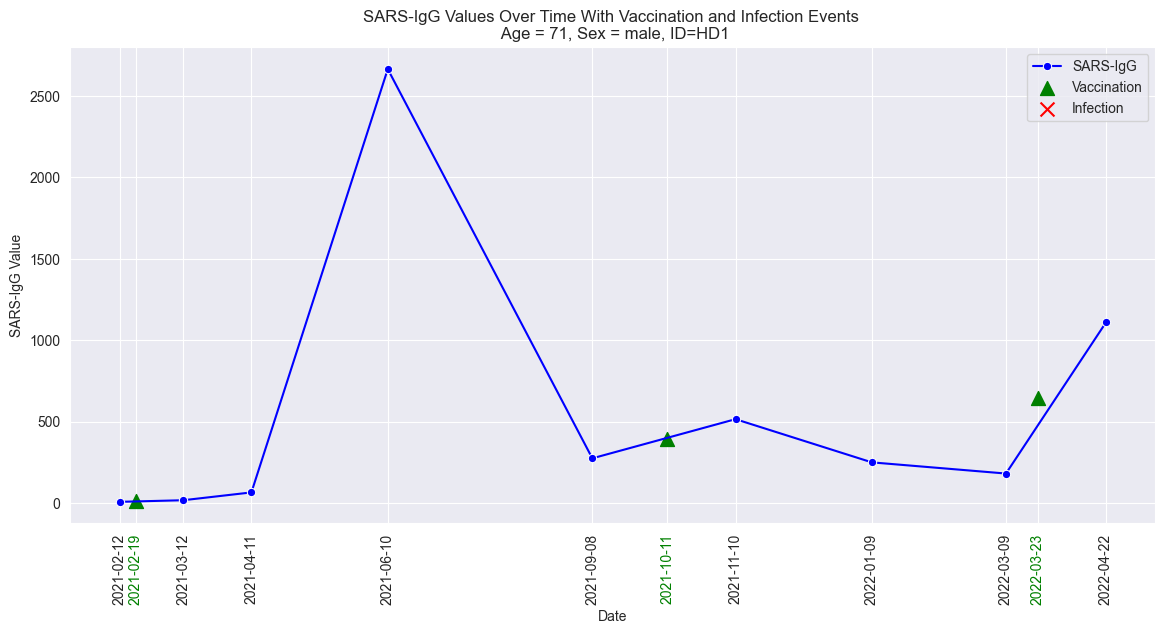

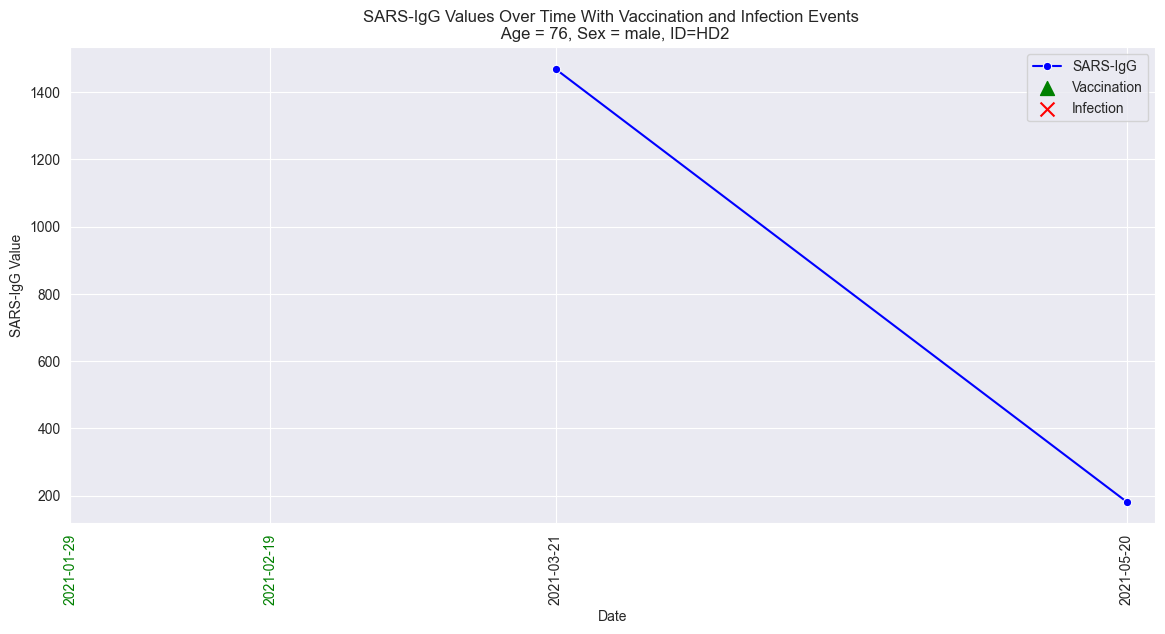

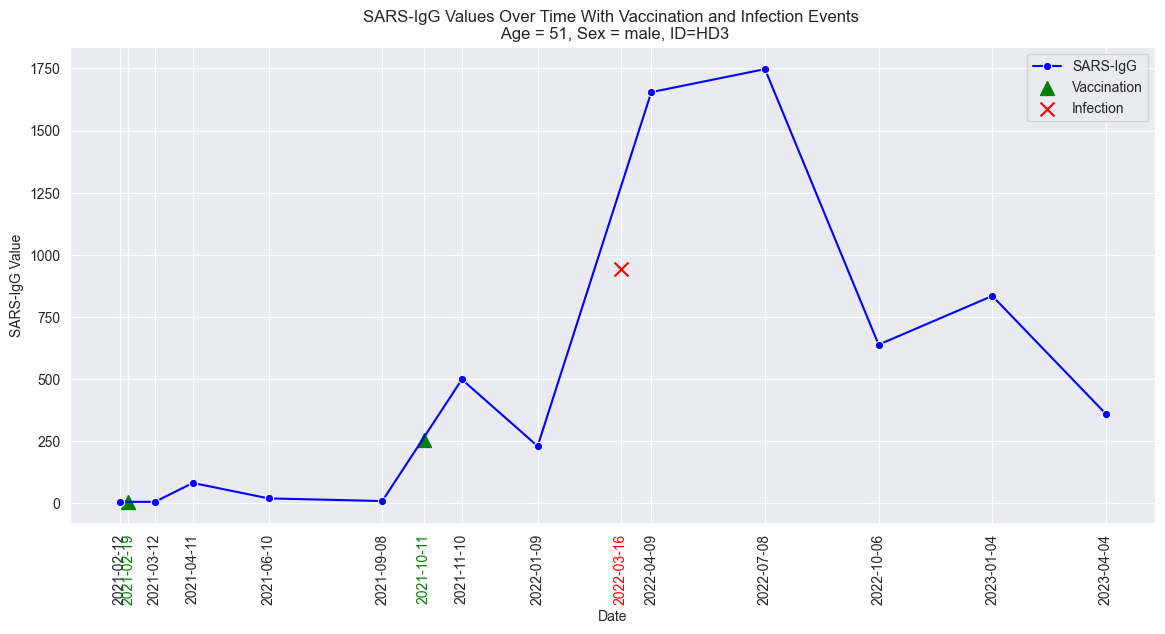

In [5]:
# loop over all patients and create single plots of their specific values
results_path = '../../results/rq1/sars-igg-plots-by-patient'
for id in df.ID.unique()[:3]:
    bl_s = bl_sub[bl_sub['ID'] == id]
    df_s = df[df['ID'] == id]
    h.plot_sars_igg_with_events(df_s, results_path, bl_s, show_plot=True)

In [6]:
# reset index for easier mapping
bl = bl.set_index('ID')

# try to aggregate values and plot these on a time axis
vaccination_groups = dict(df.groupby(['ID'])['vaccination'].sum())
infection_groups = dict(df.groupby(['ID'])['infection'].sum())

In [7]:
# count number of vaccinations and infections
bl['n_vaccinations'] = None
for id in vaccination_groups.keys():
    bl.loc[id, 'n_vaccinations'] = vaccination_groups[id]

bl['n_infections'] = None
for id in infection_groups.keys():
    bl.loc[id, 'n_infections'] = infection_groups[id]

In [8]:
# merge this information into df
sub_df = pd.merge(df, bl[['n_vaccinations','n_infections']], how='left', left_on='ID', right_index=True)
# assign group ids
sub_df['group_id'] = sub_df.groupby(['Dialyse','n_vaccinations']).ngroup()

In [9]:
# sort by date and calculate n_vaccinations and n_infections until current date
sub_df = sub_df.sort_values(by='date')
sub_df['n_vaccinations_so_far'] = sub_df.groupby('ID')['vaccination'].cumsum()
sub_df['n_infections_so_far'] = sub_df.groupby('ID')['infection'].cumsum()

In [10]:
# Ensure the DataFrame is sorted by date
sub_df.sort_values(by='date', inplace=True)

# List to hold the DataFrame of each user after applying the function
dfs = []

# Group by user_id and apply the function to each group
for _, group in sub_df.groupby('ID'):
    group_result = h.calculate_days_since_last_event(group, event_col='vaccination')
    dfs.append(group_result)

# Concatenate all the individual user DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

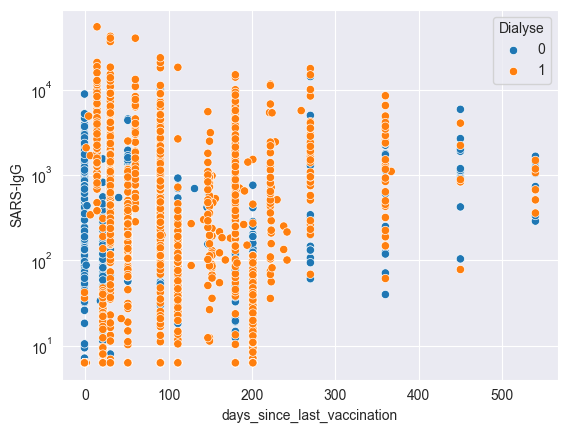

In [11]:
sns.scatterplot(result_df, y='SARS-IgG', x='days_since_last_vaccination', hue='Dialyse')
plt.yscale('log')

In [12]:
# plausible values?
result_df[result_df['SARS-IgG']>30000]

,date,ID,vaccination,timepoint,SARS-IgG,infection,Dialyse,n_vaccinations,n_infections,group_id,n_vaccinations_so_far,n_infections_so_far,days_since_last_vaccination
1415,2022-12-14,HD100,0,T32,42573.22,0,1,4,0,8,4,0,30
1855,2022-12-14,HD129,0,T32,36876.43,0,1,5,1,9,5,1,30
2901,2022-11-28,HD74,0,T31e,55047.60,0,1,4,1,8,4,1,14
2902,2022-12-14,HD74,0,T32,40542.73,0,1,4,1,8,4,1,30
3229,2023-01-14,HD97,0,"T32,5",40453.08,0,1,5,1,9,5,1,60
